In [4]:
import numpy as np
from astropy.io import fits

TIC = 350842552

import lightkurve as lk
lcs = lk.search_lightcurve(f"TIC {TIC}", exptime='short', author='SPOC').download_all()

import matplotlib.pyplot as plt
lc = lcs.stitch()

In [5]:
all_t = lc.time.value
s1 = (all_t > (2.2507e3+.005)) & (all_t < (2.2507e3+.045))
s2 = (all_t > (2.2507e3+.035)) & (all_t < (2.2507e3+.1))

μ = float(np.average(lc[s2].flux, weights=1/lc[s2].flux_err**2))
σ = float(np.sqrt(np.average((lc[s2].flux - μ)**2, weights=1/lc[s2].flux_err**2)))

x = lc[s1].time.value
y = np.array(lc[s1].flux.value)/μ
e_y = np.array(lc[s1].flux_err.value)/μ

In [6]:
def model(t, L, t0, t1, fpeak, C, τfast, τslow):
    return L + np.where(t < t0, 0, np.where(t < t1, (t - t0)/(t1 - t0) * fpeak,
                    fpeak * (C * np.exp(-(t-t1)/τfast) + (1-C) * np.exp(-(t-t1)/τslow))))

# let's set up MCMC

def log_L(θ):
    return -.5*np.sum((model(x, *θ) - y)**2 / e_y**2)

def ptform(u):
    L = 0.998 + 0.004 * u[0]
    t0 = 2.2507e3 + (.02 + .005 * u[1])
    t1 = t0 + .005 * u[2]
    fpeak = .006 * u[3]
    C = u[4]
    τfast = .0001 + .006 * u[5]
    τslow = .0001 + .006 * u[6]
    
    return [L, t0, t1, fpeak, C, τfast, τslow]

import dynesty

sampler = dynesty.DynamicNestedSampler(log_L, ptform, 7, s)

In [103]:
sampler.run_nested()
sampler.save("samples")

14514it [01:52, 129.19it/s, batch: 6 | bound: 36 | nc: 9 | ncall: 470205 | eff(%):  3.087 | loglstar: -18.317 < -12.649 < -13.758 | logz: -20.657 +/-  0.073 | stop:  0.934]          


In [10]:
sampler = sampler.restore("samples")

In [12]:
weights = np.exp(sampler.results.logwt - sampler.results.logz[-1])
samples = sampler.results.samples
mean, cov = dynesty.utils.mean_and_cov(samples, weights)
new_samples = dynesty.utils.resample_equal(samples, weights)

In [13]:
new_samples[-1]

array([9.99971910e-01, 2.25072159e+03, 2.25072244e+03, 5.16393444e-03,
       6.77004557e-01, 6.23799928e-04, 2.95149739e-03])

In [14]:
mean

array([9.99931057e-01, 2.25072126e+03, 2.25072205e+03, 4.42997263e-03,
       5.01668549e-01, 2.38069704e-03, 2.41971586e-03])

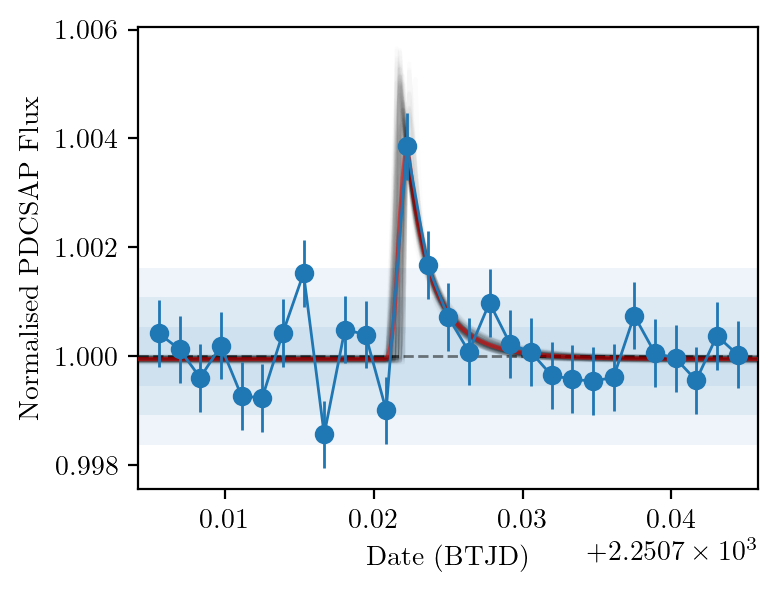

In [15]:
plt.axhline(1, c='black', ls='dashed', lw=1, alpha=.5)
plt.errorbar(x, y, yerr=e_y, fmt='o-', lw=1, zorder=10)

for n in range(1,4):
    plt.axhspan(1-n*σ/μ, 1+n*σ/μ, alpha=.075)

dt = np.median(np.diff(x))
t = np.linspace(np.min(x)-dt, np.max(x)+dt, 200)
for θ in new_samples[-150:]:
    plt.plot(t, model(t, *θ), c='black', alpha=.01)

plt.plot(t, np.mean([model(t, *θ) for θ in new_samples[-150:]], axis=0),
         c='red', alpha=.5, zorder=9)

plt.ylabel(r"Normalised PDCSAP Flux")
plt.xlabel(r"Date (BTJD)")
plt.xlim(np.min(x)-dt, np.max(x)+dt)

plt.gcf().set_size_inches(4,3)
plt.savefig(r"marginal.pdf", bbox_inches='tight', transparent=True)
plt.show()